In [77]:
import numpy as np
import pandas as pd
import scanpy as sc

In [78]:
#creates master list of circle splitting coordinates for n=2:20
#source: http://www.packomania.com/
coords=[]
for i in range(1,20):
    path="./cci_coords/cci"+str(i)+".txt"
    cci=np.loadtxt(path, usecols = (1,2))
    coords.append(cci)

In [79]:
def circle_split(original_coords, coords, n, r):
    #original_coords: coordinates for original spot's centroid 
    #coords: master list of how to split circles, each row corresponds to a different n
    #n: number of new circles n (1-indexed and cannot=1)
    #r: radius of original spot, available from json file (coords are for unit circle)
    
    #returns n coordinates for each new spot's centroids
    
    new_circles=[]
    for i in range(n):
        x = original_coords[1]+coords[n-1][i][0]*r 
        y = original_coords[0]+coords[n-1][i][1]*r
        new_circles.append([y,x])
    #note, visium data comes in columns first, then rows, so the return is [y,x]
    return new_circles

In [80]:
spots_fulldata = pd.read_csv("./spatial/tissue_positions_list.csv",header=None)

In [81]:
spots = pd.read_csv("./spatial/tissue_positions_list.csv",header=None, index_col=0,usecols=[0,4,5])


In [161]:
avgexp_str=[]
indes=avgexp.index.values
for i in indes:
    avgexp_str.append(str(i.split("'")[1]))

In [162]:
#filter to only spots that are in the adata
indata_spots = avgexp_str
for i in spots.index.values:
    if (i in indata_spots)==False:
        spots=spots.drop(i)

In [56]:
spots.shape

(4992, 2)

In [151]:
#divide each spot into appropriate number of components
#spots = spots.to_numpy()
components = []
for i in range(spots.shape[0]):
    if spots_fulldata.iloc[i][1]==1:
        components+=circle_split(spots[i],coords,3,268.7845927947693/2) #radius is spot_diameter_fullres/2 from json file

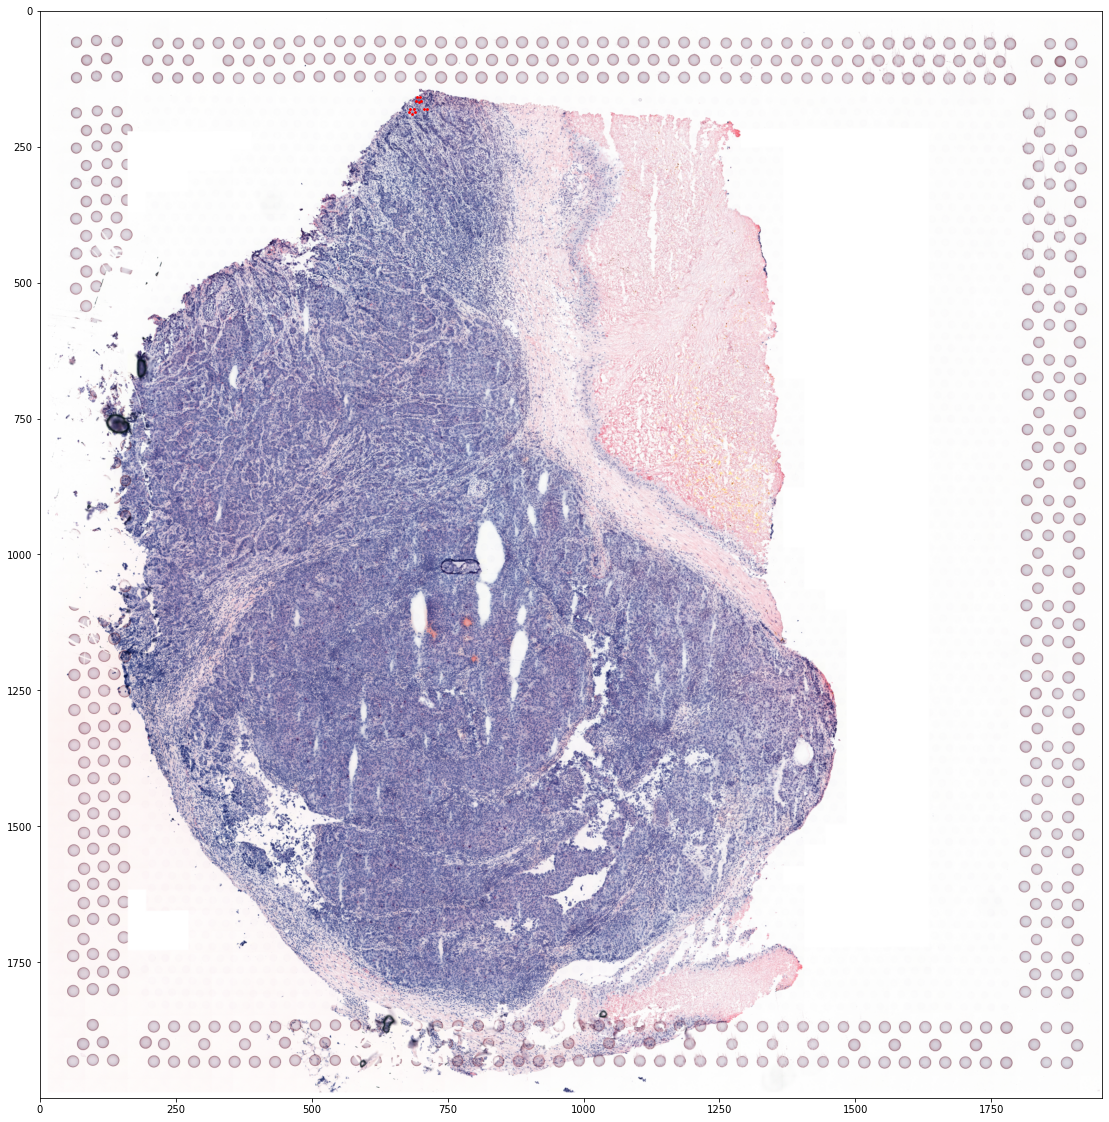

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
im = plt.imread("./spatial/tissue_hires_image.png")
implot = plt.imshow(im)
for i in range(12):
    plt.scatter(components[i][1]*0.060096152,components[i][0]*0.060096152,s=3,c="red") #multiply by tissue_hires_scalef scaling factor

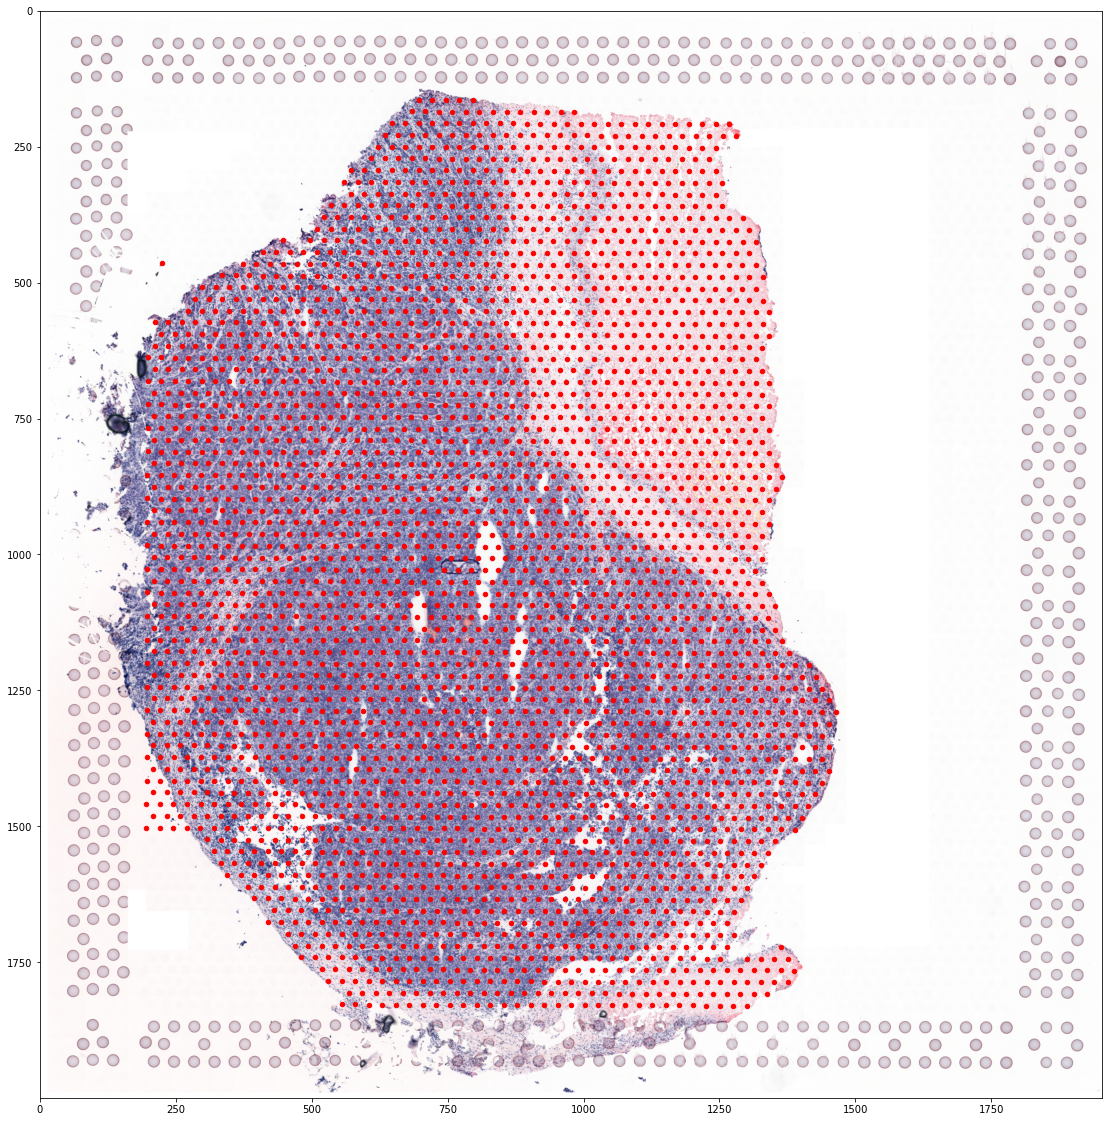

In [152]:
plt.figure(figsize = (20,20))
im = plt.imread("./spatial/tissue_hires_image.png")
implot = plt.imshow(im)

spotsin=[]
for i in range(spots.shape[0]):
    if spots_fulldata.iloc[i][1]==1:
        spotsin.append(spots[i])
for i in range(len(spotsin)):
    plt.scatter(spotsin[i][1]*0.060096152,spotsin[i][0]*0.060096152,s=20,c="red") #multiply by tissue_hires_scalef scaling factor

In [28]:
factorized = pd.read_csv("./patient2_Factorized_1")

In [29]:
factorized.shape

(20, 33539)

In [84]:
#CODE COPIED FROM SCANPY
adata = sc.read_visium('./', count_file='./patient-gene-matrices_2A_filtered_feature_bc_matrix.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [85]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [4]:
sc.pp.filter_cells(adata, min_counts=5000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 2693


Trying to set attribute `.var` of view, copying.


In [5]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [6]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

In [25]:
#only look at one cluster
cluster1ind=[]
for i in range(adata.obs["clusters"].shape[0]):
    if adata.obs["clusters"][i]=="1":
        cluster1ind.append(i)

In [27]:
len(cluster1ind)

385

PLOT MIXING

In [128]:
avgexp=pd.read_csv("./df_spots_avgexp_celltypes_COUNTS_A_ONLY_unfiltered_WITH BARCODES-2.csv",index_col=0)

In [170]:
avgexp[0:4]

myeloid   NK  macrophage  b_cell  hsc  t_cell  t_reg  \
('AAACAATCTACTAGCA-1',)     7.25  2.0         1.0     0.5  0.0     2.0    1.0   
('AAACACCAATAACTGC-1',)     9.75  8.0         0.0     0.5  1.0     1.5    0.0   
('AAACAGCTTTCAGAAG-1',)    28.00  2.0         0.5     0.5  0.0     1.5    1.0   
('AAACAGGGTCTATATT-1',)     8.50  2.5         0.0     0.0  0.0     1.5    0.0   

                         prolif  endothelial  breast_cancer  
('AAACAATCTACTAGCA-1',)     0.0          0.0       0.794118  
('AAACACCAATAACTGC-1',)     1.0          2.0       0.588235  
('AAACAGCTTTCAGAAG-1',)     0.0          2.0       0.441176  
('AAACAGGGTCTATATT-1',)     5.0          0.0       0.705882

In [145]:
list(avgexp)

['myeloid',
 'NK',
 'macrophage',
 'b_cell',
 'hsc',
 't_cell',
 't_reg',
 'prolif',
 'endothelial',
 'breast_cancer']

In [171]:
types[0:20]

[0, 5, 1, 0, 0, 0, 1, 8, 5, 0, 0, 8, 1, 5, 0, 0, 7, 1, 5, 0]

In [137]:
def define_types(avgexp,n):
    #unpack each spot into n components with highest values
    types=[]
    for i in range(avgexp.shape[0]):
        #get indices of sorted array in ascending order
        argsort=np.argsort(avgexp[i])
        #for each desired component
        for j in range(1,n+1):
            if avgexp[i][argsort[argsort.shape[0]-j]]>.1:
                types.append(argsort[argsort.shape[0]-j])
            
            else: 
                types.append(argsort[argsort.shape[0]-1])
    return types
        

In [269]:
types=define_types(np.asarray(groupedWnorm),1)

In [267]:
components=np.asarray(components)

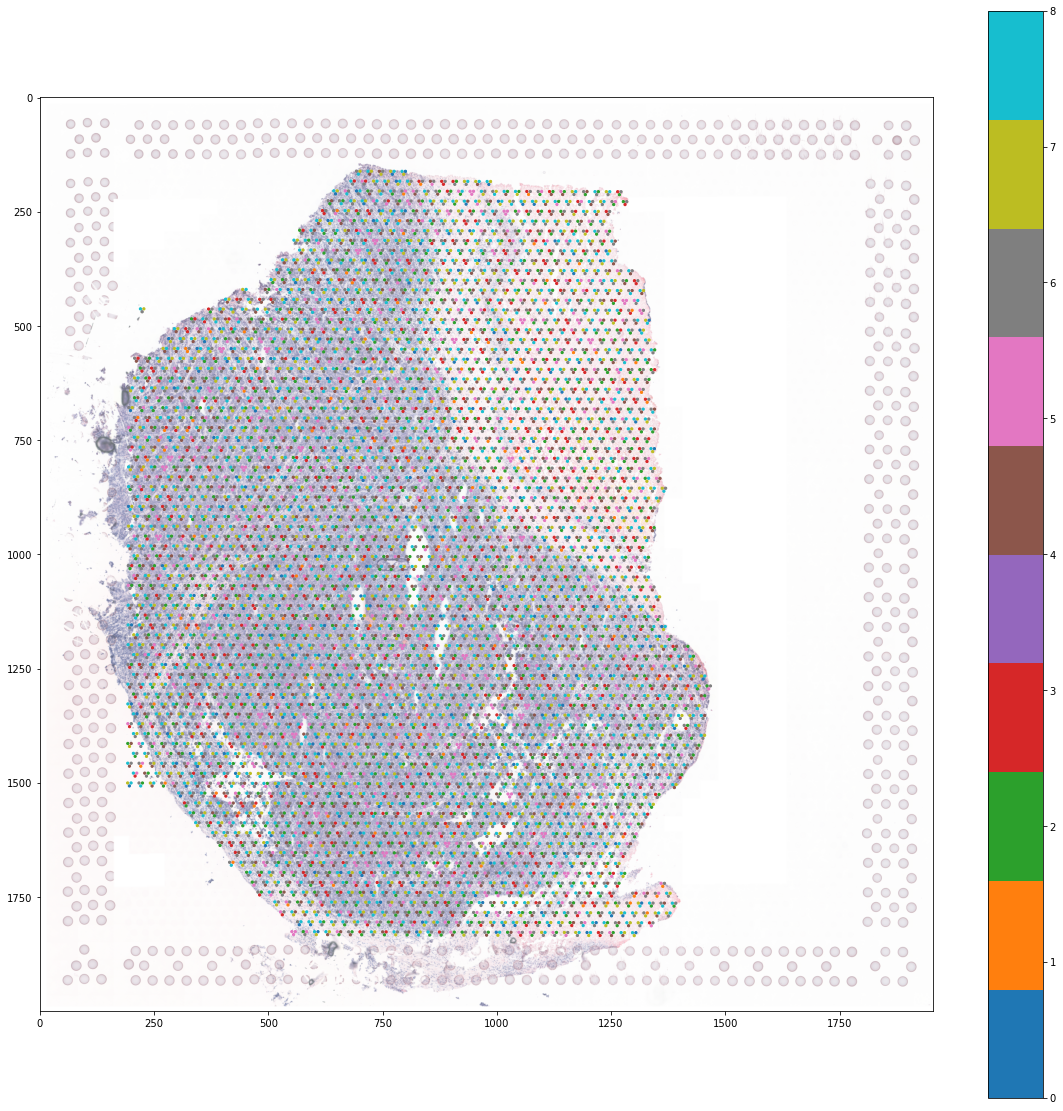

In [268]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
im = plt.imread("./spatial/tissue_hires_image.png")
implot = plt.imshow(im,alpha=0.6)

plt.scatter(components[:,1]*0.060096152,components[:,0]*0.060096152,s=5,c=types,cmap="tab10") #multiply by tissue_hires_scalef scaling factor
plt.colorbar()

In [69]:
W.shape

(1, 50, 6446)

COLORING BY COMPONENTS

In [255]:
n_components = 50
W_load = np.loadtxt("./W_norm_50comp_DEGs.csv")

In [256]:
W = W_load.reshape(1,n_components, 6446)

In [257]:
WA=W[0][:,0:3244]

In [258]:
adata.obs['8']=WA[8,:]
adata.obs['45']=WA[45,:]
adata.obs['49,28,41']=WA[49,:]+WA[28,:]+WA[41,:]
adata.obs['5,10,25']=WA[5,:]+WA[10,:]+WA[25,:]
adata.obs['29,11,42']=WA[29,:]+WA[11,:]+WA[42,:]
adata.obs['7, 0, 3']=WA[7,:]+WA[0,:]+WA[3,:]
adata.obs['35,6,18,44']=WA[35,:]+WA[6,:]+WA[18,:]+WA[44,:]
adata.obs['32,46']=WA[32,:]+WA[46,:]
adata.obs['24,1,23']=WA[24,:]+WA[1,:]+WA[23,:]


In [259]:
groupedW=[]
groupedW.append(list(adata.obs['8']))
groupedW.append(list(adata.obs['45']))
groupedW.append(list(adata.obs['49,28,41']))
groupedW.append(list(adata.obs['5,10,25']))
groupedW.append(list(adata.obs['29,11,42']))
groupedW.append(list(adata.obs['7, 0, 3']))
groupedW.append(list(adata.obs['35,6,18,44']))
groupedW.append(list(adata.obs['32,46']))
groupedW.append(list(adata.obs['24,1,23']))

In [260]:
groupedW=np.asarray(groupedW)
groupedW=np.transpose(groupedW)

In [261]:
groupedWnorm=[]
for i in groupedW:
    groupedWnorm.append(i/np.sum(i))

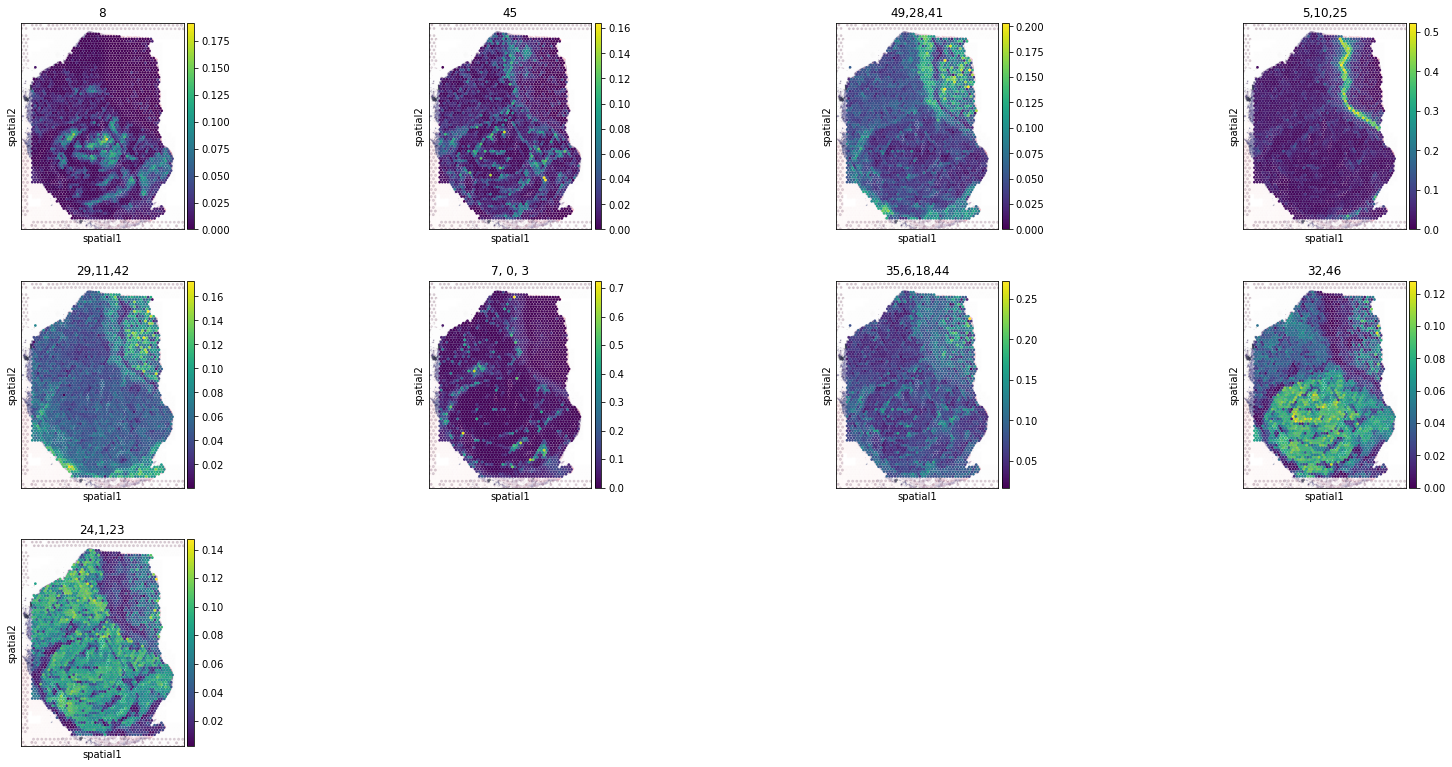

In [279]:
sc.pl.spatial(adata, img_key="hires", color=["8",'45','49,28,41','5,10,25','29,11,42','7, 0, 3','35,6,18,44','32,46','24,1,23'], size=1.5, save=True)

In [270]:
strtype=[]
for i in types:
    strtype.append(str(i))

In [271]:
adata.obs["top component"]=strtype

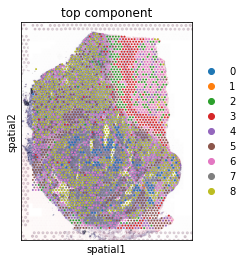

In [280]:
sc.pl.spatial(adata, img_key="hires", color=["top component"],save=True)

In [273]:
def degree_of_mix(W,thresh):
    #degree of mixing is determined based on a "cdf"-like approach, we count how many components it takes to reach threhsold
    degree_of_mixing=[]
    for i in range(W.shape[0]):
        props=np.sort(W[i])
        count=0
        cdf=0
        while cdf<thresh:
            count+=1
            cdf+=props[props.shape[0]-count] 
        degree_of_mixing.append(count)
    return degree_of_mixing

In [274]:
mixing=degree_of_mix(np.asarray(groupedWnorm),0.6)

In [275]:
adata.obs["mixing"]=mixing

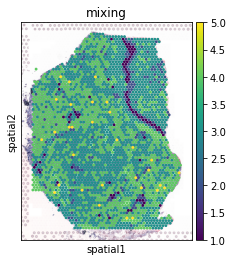

In [277]:
sc.pl.spatial(adata, img_key="hires", color=["mixing"], size=1.5,save=True)